##### Since shap and imblearn were not installed initially, the package installer for Python was run for both of these.

In [2]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import shap

from numpy.testing import assert_almost_equal
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset 
<p>
1. Age – refers to the age of the primary beneficiary of the insurance holder, ranges from 18 to 64 <br>
2. Sex – refers to the gender of the insurance holder, either male or female <br>
3. BMI – gives a viewer a background on the health of the insurance holder based on weight and height, ranges from 16 to 53.1 <br>
4. Children – refers to the number of children or dependents covered by the health insurance <br>
5. Smoker – determines whether the insurance holder is a smoker or a non-smoker, categorized into yes or no <br>
6. Region – gives the residential location of the insurance holder, whether they are in the northeast, northwest, southeast, or southwest <br>
7. Charges – determines the medical costs billed by the health insurance in one year, ranges from about 1.12k to 63.8k USD<br>
</p>

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##### The table above shows an overview of the dataset to be used for this project.

## <span style="color:blue">Exploratory Data Analysis</span>
<hr>

# Which gender is prone to higher than averages charges?

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

##### We can see from the output above that there are no null values in all the columns of the dataset, thus there is no need to drop or fill any rows. Imputation would not be necessary.

In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


##### The table above shows the statistical data for the float data types in the dataset.

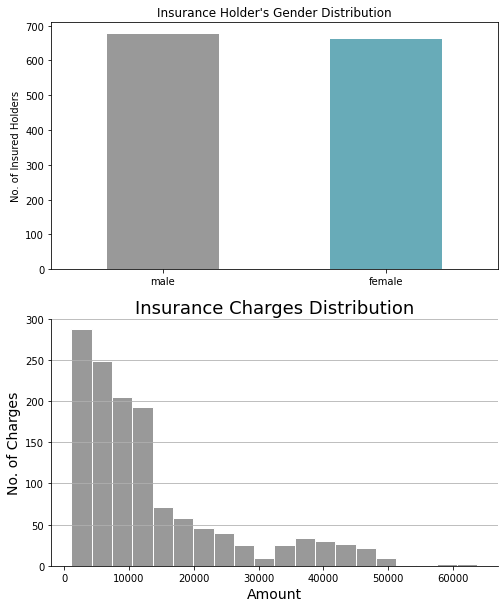

In [8]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(2,1,1)

ax = df['sex'].value_counts().plot(figsize=(8, 10), kind='bar', color=['#999999', '#68abb8'], width=0.5)

ax.set_xticklabels(['male', 'female'], rotation=0)
ax.set_title('Insurance Holder\'s Gender Distribution')
ax.set_ylabel('No. of Insured Holders');

ax2 = fig.add_subplot(2,1,2)

df['charges'].hist(ax=ax2, bins=20, edgecolor='w', color='#999999')
ax2.set_title('Insurance Charges Distribution', fontsize=18)
ax2.set_xlabel('Amount', fontsize=14)
ax2.set_ylabel('No. of Charges', fontsize=14)
ax2.set_ylim([0, 300]) 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.grid(False)
fig.savefig("figures/gender_and_charges_distribution.png")


##### Based on the bar graph showing the number of insured holders per gender, there are more males than females. This means that there is a need to underfit the data for males to ensure that the data is balanced for both genders and that there is an equal target distribution.

##### The histogram shows the distribution of the bill charges and the number of insurance holders with the corresponding charge. It can be observed that there is a general trend where the number of holders decreases as the amount increases. Additionally, a huge chunk of the data represents insurance holders with medical costs of US$ 3,000-12,000.

In [9]:
# sns.distplot(df['charges'], bins=10)
# plt.tight_layout()
# plt.show()

## <span style="color:blue">Data Preprocessing</span>
<hr>

``This section contains the application of undersampling for the analyzed imblanced data. Data imputation is not necessary as the dataset has no null values. OneHotEncoding is applied for the categorical features.``

In [10]:
# print(df['x0_female'].value_counts())
# print(df['x0_male'].value_counts())

In [11]:
X = df.drop(labels=['sex'], axis=1)
y = df['sex']

In [12]:
undersampler = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = undersampler.fit_resample(X, y)

print(f"# of data points before resampling {len(y)}")
print(f"# of data points after resampling {len(y_under)}")
print(f"target distribution before resampling {Counter(y)}")
print(f"target distribution after resampling {Counter(y_under)}")

# of data points before resampling 1338
# of data points after resampling 1324
target distribution before resampling Counter({'male': 676, 'female': 662})
target distribution after resampling Counter({'female': 662, 'male': 662})


##### In the code block above, undersampling was done to randomly remove data from males. The sampling_strategy is 1, so the ratio of the number of samples in the majority class and the number of samples in the minority class is equal to 1, meaning that they have the same number of data for both genders. We can see here that the number of rows for males before undersampling was done was 676, and after undersampling, it was reduced to the same number of rows for females, which is 662.

In [13]:
# from imblearn.over_sampling import SMOTE

# oversampler = SMOTE(sampling_strategy=1, k_neighbors=6)
# X_over, y_over = oversampler.fit_resample(X, y)

# print(f"# of data points before resampling {len(y)}")
# print(f"# of data points after resampling {len(y_over)}")
# print(f"target distribution before resampling {Counter(y)}")
# print(f"target distribution after resampling {Counter(y_over)}")

In [14]:
X_under.count()

age         1324
bmi         1324
children    1324
smoker      1324
region      1324
charges     1324
dtype: int64

In [15]:
y_under

0       female
1       female
2       female
3       female
4       female
         ...  
1319      male
1320      male
1321      male
1322      male
1323      male
Name: sex, Length: 1324, dtype: object

In [16]:
X_under.head()

,age,bmi,children,smoker,region,charges
0,19,27.90,0,yes,southwest,16884.92400
1,31,25.74,0,no,southeast,3756.62160
2,46,33.44,1,no,southeast,8240.58960
3,37,27.74,3,no,northwest,7281.50560
4,60,25.84,0,no,northwest,28923.13692


In [17]:
df_gender = pd.DataFrame(y_under)

In [18]:
df_gender.head()

,sex
0,female
1,female
2,female
3,female
4,female


In [19]:
model_data = pd.merge(X_under, df_gender, left_index=True, right_index=True)

In [20]:
model_data

,age,bmi,children,smoker,region,charges,sex
0,19,27.90,0,yes,southwest,16884.92400,female
1,31,25.74,0,no,southeast,3756.62160,female
2,46,33.44,1,no,southeast,8240.58960,female
3,37,27.74,3,no,northwest,7281.50560,female
4,60,25.84,0,no,northwest,28923.13692,female
...,...,...,...,...,...,...,...
1319,40,41.69,0,no,southeast,5438.74910,male
1320,32,30.80,3,no,southwest,5253.52400,male
1321,30,24.13,1,no,northwest,4032.24070,male
1322,44,39.52,0,no,northwest,6948.70080,male


##### Since gender was initially dropped from the dataset to do the underfitting, it was merged back with the other columns as shown in the table above for further analysis later on.

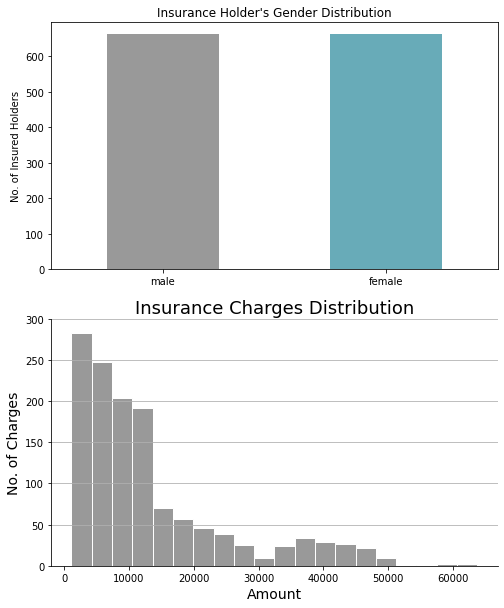

In [21]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(2,1,1)

ax = model_data['sex'].value_counts().plot(figsize=(8, 10), kind='bar', color=['#999999', '#68abb8'], width=0.5)

ax.set_xticklabels(['male', 'female'], rotation=0)
ax.set_title('Insurance Holder\'s Gender Distribution')
ax.set_ylabel('No. of Insured Holders');

ax2 = fig.add_subplot(2,1,2)

model_data['charges'].hist(ax=ax2, bins=20, edgecolor='w', color='#999999')
ax2.set_title('Insurance Charges Distribution', fontsize=18)
ax2.set_xlabel('Amount', fontsize=14)
ax2.set_ylabel('No. of Charges', fontsize=14)
ax2.set_ylim([0, 300]) 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.grid(False)
fig.savefig("figures/new_gender_and_charges_distribution.png")

##### From the bar graph above, we can see that the number of data for both male and female are now the same after handling the initially imbalanced data.

In [22]:
gender_and_charges = model_data[['sex', 'charges']]

In [23]:
gender_and_charges.head()

,sex,charges
0,female,16884.92400
1,female,3756.62160
2,female,8240.58960
3,female,7281.50560
4,female,28923.13692


##### To answer the question "Which gender is prone to higher than average charges?", the mean of the charges for both genders was determined. Afterwards, the charges for females that are higher than this determined average were determined then summed up. The same method is applied for males. After summing up all these higher than average charges, since the sum for males was higher, it became the answer to the question.

In [24]:
gender_and_charges["charges"].mean()

13271.02179645695

In [25]:
high_charges_and_gender = gender_and_charges.loc[gender_and_charges['charges'] >= gender_and_charges["charges"].mean()]

In [26]:
high_charges_and_gender.head()

,sex,charges
0,female,16884.92400
4,female,28923.13692
5,female,27808.72510
10,female,37701.87680
11,female,14001.13380


In [27]:
high_charges_and_gender.tail()

,sex,charges
1295,male,38711.0000
1297,male,18972.4950
1300,male,38415.4740
1311,male,21223.6758
1313,male,38709.1760


In [28]:
high_charges_and_gender.groupby("sex").sum().style.format("{:.1f}")

,charges
sex,
female,5154331.8
male,6368854.8


##### It can be deduced that the male insurance holder are prone to higher insurance charges due to their approximately US$ 1 million higher in charges compared to the female insurance holders whose charges are above the overall mean. As a recommendation, the insurance company should research on why males are often a riskier customer and how they should help them with their health insurance.

In [29]:
features = df.columns

In [30]:
features

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [31]:
categorical_features = ['region', 'sex', 'smoker']
categorical_features

['region', 'sex', 'smoker']

In [32]:
enc = OneHotEncoder(handle_unknown='ignore')
res = enc.fit_transform(df[categorical_features])
res_df = pd.DataFrame(res.todense(), columns=enc.get_feature_names())

df.drop(categorical_features, axis=1, inplace=True)
df = pd.concat([df, res_df], axis=1)

df.head()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,age,bmi,children,charges,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x1_female,x1_male,x2_no,x2_yes
0,19,27.900,0,16884.92400,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [33]:
df.head()

,age,bmi,children,charges,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x1_female,x1_male,x2_no,x2_yes
0,19,27.900,0,16884.92400,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [34]:
df['charges'] = round(df['charges']).astype(int)

In [35]:
df['charges'] = df['charges'].apply(lambda x: 1 if x >= df["charges"].mean() else 0) 

In [36]:
df.head()

,age,bmi,children,charges,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x1_female,x1_male,x2_no,x2_yes
0,19,27.900,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,18,33.770,1,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,28,33.000,3,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,33,22.705,0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,32,28.880,0,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [37]:
X = df.drop(labels=['charges'], axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train ", X_train.shape)
print("Test ", X_test.shape)

Train  (1070, 11)
Test  (268, 11)


In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector

In [39]:
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=.8)
sfs.fit(X_train, y_train)
X_train.columns[sfs.get_support()]

Index(['age', 'x0_northeast', 'x0_northwest', 'x0_southwest', 'x1_female',
       'x1_male', 'x2_no', 'x2_yes'],
      dtype='object')

In [40]:
estimator = LogisticRegression(solver='saga', max_iter=1000000)

In [41]:
rfecv = RFECV(estimator=estimator, scoring='accuracy', min_features_to_select=5, n_jobs=-1)
rfecv.fit(X, y)

RFECV(estimator=LogisticRegression(max_iter=1000000, solver='saga'),
      min_features_to_select=5, n_jobs=-1, scoring='accuracy')

In [42]:
rfecv.cv_results_

{'mean_test_score': array([0.8894041, 0.8894041, 0.8894041, 0.8894041, 0.8894041, 0.8894041,
        0.8894041]),
 'std_test_score': array([0.01734291, 0.01734291, 0.01734291, 0.01734291, 0.01734291,
        0.01734291, 0.01734291]),
 'split0_test_score': array([0.90298507, 0.90298507, 0.90298507, 0.90298507, 0.90298507,
        0.90298507, 0.90298507]),
 'split1_test_score': array([0.85820896, 0.85820896, 0.85820896, 0.85820896, 0.85820896,
        0.85820896, 0.85820896]),
 'split2_test_score': array([0.88432836, 0.88432836, 0.88432836, 0.88432836, 0.88432836,
        0.88432836, 0.88432836]),
 'split3_test_score': array([0.89513109, 0.89513109, 0.89513109, 0.89513109, 0.89513109,
        0.89513109, 0.89513109]),
 'split4_test_score': array([0.90636704, 0.90636704, 0.90636704, 0.90636704, 0.90636704,
        0.90636704, 0.90636704])}

In [43]:
# ax = sns.lineplot(x=list(range(1, len(rfecv.grid_scores_[0])+1)), y=list(rfecv.grid_scores_[0]))
# ax.set_title("Accuracy vs # of Features")
# ax.set_xlabel("# of Features")
# ax.set_ylabel("Accuracy")
# ax.set_ylim(.85, 1.0)
# sns.set(rc={'figure.figsize':(10,5)})

In [44]:
temp_df = pd.DataFrame() 
temp_df['feature'] = X_train.columns
temp_df['rank'] = rfecv.ranking_
temp_df = temp_df.sort_values("rank")

In [45]:
temp_df

,feature,rank
3,x0_northeast,1
6,x0_southwest,1
7,x1_female,1
9,x2_no,1
10,x2_yes,1
8,x1_male,2
2,children,3
0,age,4
4,x0_northwest,5
5,x0_southeast,6


In [46]:
estimator = SVC(kernel="linear")

In [47]:
rfecv = RFECV(estimator=estimator, scoring='accuracy', min_features_to_select=5)
rfecv.fit(X, y)

RFECV(estimator=SVC(kernel='linear'), min_features_to_select=5,
      scoring='accuracy')

In [48]:
rfecv.cv_results_

{'mean_test_score': array([0.8894041, 0.8894041, 0.8894041, 0.8894041, 0.8894041, 0.8894041,
        0.8894041]),
 'std_test_score': array([0.01734291, 0.01734291, 0.01734291, 0.01734291, 0.01734291,
        0.01734291, 0.01734291]),
 'split0_test_score': array([0.90298507, 0.90298507, 0.90298507, 0.90298507, 0.90298507,
        0.90298507, 0.90298507]),
 'split1_test_score': array([0.85820896, 0.85820896, 0.85820896, 0.85820896, 0.85820896,
        0.85820896, 0.85820896]),
 'split2_test_score': array([0.88432836, 0.88432836, 0.88432836, 0.88432836, 0.88432836,
        0.88432836, 0.88432836]),
 'split3_test_score': array([0.89513109, 0.89513109, 0.89513109, 0.89513109, 0.89513109,
        0.89513109, 0.89513109]),
 'split4_test_score': array([0.90636704, 0.90636704, 0.90636704, 0.90636704, 0.90636704,
        0.90636704, 0.90636704])}

In [49]:
# ax = sns.lineplot(x=list(range(1, len(rfecv.grid_scores_[0])+1)), y=list(rfecv.grid_scores_[0]))
# ax.set_title("Accuracy vs # of Features")
# ax.set_xlabel("# of Features")
# ax.set_ylabel("Accuracy")
# ax.set_ylim(.85, 1.0)
# sns.set(rc={'figure.figsize':(10,5)})

In [50]:
temp_df = pd.DataFrame() 
temp_df['feature'] = X_train.columns
temp_df['rank'] = rfecv.ranking_
temp_df = temp_df.sort_values("rank")

In [51]:
temp_df

,feature,rank
2,children,1
4,x0_northwest,1
8,x1_male,1
9,x2_no,1
10,x2_yes,1
7,x1_female,2
3,x0_northeast,3
5,x0_southeast,4
6,x0_southwest,5
0,age,6


In [52]:
X_train.value_counts('x0_northeast')

x0_northeast
0.0    805
1.0    265
dtype: int64

In [53]:
X_train.value_counts('x0_northwest')

x0_northwest
0.0    811
1.0    259
dtype: int64

In [54]:
X_train.value_counts('x0_southeast')

x0_southeast
0.0    775
1.0    295
dtype: int64

In [55]:
X_train.value_counts('x0_southwest')

x0_southwest
0.0    819
1.0    251
dtype: int64

## <span style="color:blue">Model Development</span>
<hr>

In [56]:
X = df[temp_df['feature']]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train ", X_train.shape)
print("Test ", X_test.shape)

Train  (1070, 11)
Test  (268, 11)


In [57]:
knn_params = {
    "n_neighbors": np.arange(1, 20), 
    "weights": ["uniform", "distance"], 
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
}

knn_estimator = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_estimator, knn_params, scoring=scorers, cv=10, refit='precision_score', verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)
knn_model = knn_cv.best_estimator_

Fitting 10 folds for each of 38 candidates, totalling 380 fits
[CV 4/10] END n_neighbors=1, weights=uniform; accuracy_score: (test=0.729) f1: (test=0.540) precision_score: (test=0.586) recall_score: (test=0.500) total time=   0.0s
[CV 6/10] END n_neighbors=1, weights=uniform; accuracy_score: (test=0.776) f1: (test=0.625) precision_score: (test=0.667) recall_score: (test=0.588) total time=   0.0s
[CV 10/10] END n_neighbors=1, weights=uniform; accuracy_score: (test=0.776) f1: (test=0.636) precision_score: (test=0.636) recall_score: (test=0.636) total time=   0.0s
[CV 4/10] END n_neighbors=1, weights=distance; accuracy_score: (test=0.729) f1: (test=0.540) precision_score: (test=0.586) recall_score: (test=0.500) total time=   0.0s
[CV 9/10] END n_neighbors=1, weights=distance; accuracy_score: (test=0.860) f1: (test=0.746) precision_score: (test=0.846) recall_score: (test=0.667) total time=   0.0s
[CV 5/10] END n_neighbors=2, weights=uniform; accuracy_score: (test=0.748) f1: (test=0.426) pr

In [58]:
y_pred = knn_model.predict(X_test)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

0.8571428571428571
0.2857142857142857
0.42857142857142855
0.7611940298507462


``In here we should not trust the accuracy_score as the f1-score is significantly low and is not a better model for determining the features that contributes to high charges``

In [ ]:
param_grid = {
    "n_estimators": range(100, 150, 10),
    "max_depth": range(5,25,5),
    "min_samples_split": np.arange(.1,.6,.1),
    "min_samples_leaf": np.arange(.1,.6,.1),
    "max_features": np.arange(0.1, 0.6, .1)
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
}

clf = RandomForestClassifier()
clf_grid = GridSearchCV(clf, param_grid, scoring=scorers, cv=10, refit='precision_score', verbose = 3, n_jobs=-1)
clf_grid.fit(X_train, y_train)

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits
[CV 4/10] END n_neighbors=9, weights=uniform; accuracy_score: (test=0.738) f1: (test=0.364) precision_score: (test=0.800) recall_score: (test=0.235) total time=   0.0s
[CV 3/10] END n_neighbors=11, weights=distance; accuracy_score: (test=0.748) f1: (test=0.449) precision_score: (test=0.733) recall_score: (test=0.324) total time=   0.0s
[CV 4/10] END n_neighbors=11, weights=distance; accuracy_score: (test=0.729) f1: (test=0.326) precision_score: (test=0.778) recall_score: (test=0.206) total time=   0.0s
[CV 5/10] END n_neighbors=11, weights=distance; accuracy_score: (test=0.738) f1: (test=0.391) precision_score: (test=0.750) recall_score: (test=0.265) total time=   0.0s
[CV 6/10] END n_neighbors=11, weights=distance; accuracy_score: (test=0.729) f1: (test=0.356) precision_score: (test=0.727) recall_score: (test=0.235) total time=   0.0s
[CV 7/10] END n_neighbors=11, weights=distance; accuracy_score: (test=0.692) f1: (tes

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 8/10] END n_neighbors=8, weights=uniform; accuracy_score: (test=0.729) f1: (test=0.216) precision_score: (test=1.000) recall_score: (test=0.121) total time=   0.0s
[CV 7/10] END n_neighbors=10, weights=distance; accuracy_score: (test=0.701) f1: (test=0.238) precision_score: (test=0.556) recall_score: (test=0.152) total time=   0.0s
[CV 8/10] END n_neighbors=10, weights=distance; accuracy_score: (test=0.748) f1: (test=0.400) precision_score: (test=0.750) recall_score: (test=0.273) total time=   0.0s
[CV 9/10] END n_neighbors=10, weights=distance; accuracy_score: (test=0.813) f1: (test=0.583) precision_score: (test=0.933) recall_score: (test=0.424) total time=   0.0s
[CV 10/10] END n_neighbors=10, weights=distance; accuracy_score: (test=0.748) f1: (test=0.426) precision_score: (test=0.714) recall_score: (test=0.303) total time=   0.0s
[CV 1/10] END n_neighbors=11, weights=uniform; accuracy_score: (test=0.785) f1: (test=0.511) precision_score: (test=0.923) recall_score: (test=0.353) t

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.701) f1: (test=0.059) precision_score: (test=1.000) recall_score: (test=0.030) total time=   0.2s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.757) f1: (test=0.409) precision_score: (test=0.900) recall_score: (test=0.265) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.701) f1: (test=0.111) precision_score: (test=1.000) recall_score: (test=0.059) total time=   0.2s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 9/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 3/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.738) f1: (test=0.300) precision_score: (test=1.000) recall_score: (test=0.176) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=130; accuracy_score: (test=0.841) f1: (test=0.653) precision_score: (test=1.000) recall_score: (test=0.485) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.804) f1: (test=0.553) precision_score: (test=1.000) recall_score: (test=0.382) total time=   0.4s
[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 9/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.701) f1: (test=0.059) precision_score: (test=1.000) recall_score: (test=0.030) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 9/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.1, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 2/10] END max_depth=5, max_features=0.1, mi

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.5s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.2, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.2, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 7/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.2, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 3/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.2, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.2, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 3/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 9/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.4, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.30000000000000004, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.30000000000000004, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 7/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.30000000000000004, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 1/10] END max_depth=5, max_features=0.1, min

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 5/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.30000000000000004, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.30000000000000004, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 2/10] END max_depth=5, max_features=0.1, mi

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.1, min_samples_leaf=0.5, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=110; accuracy_score: (test=0.879) f1: (test=0.764) precision_score: (test=1.000) recall_score: (test=0.618) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=110; accuracy_score: (test=0.925) f1: (test=0.862) precision_score: (test=1.000) recall_score: (test=0.758) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=120; accuracy_score: (test=0.860) f1: (test=0.727) precision_score: (test=0.952) recall_score: (test=0.588) total time=   0.4s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=120; accuracy_score: (test=0.907) f1: (test=0.821) precision_score: (test=1.000) recall_score: (test=0.697) total time=   0.3s
[CV 1/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=120; accuracy_score: (test=0.850) f1: (test=0.692) precision_score: (test=1.000) recall_score: (test=0.529) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=120; accuracy_score: (test=0.879) f1: (test=0.764) precision_score: (test=1.000) recall_score: (test=0.618) total time=   0.4s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=120; accuracy_score: (test=0.860) f1: (test=0.706) precision_score: (test=1.000) recall_score: (test=0.545) total time=   0.4s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.30000000000000004, n_estimators=130; accuracy_score: (test=0.916) f1: (test=0.847) precision_score: (test=1.000) recall_score: (test=0.735) total time=   0.4s
[CV 7/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=140; accuracy_score: (test=0.869) f1: (test=0.731) precision_score: (test=1.000) recall_score: (test=0.576) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.30000000000000004, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 4/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 10/10] END max_depth=5, max_features=0.2, mi

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.30000000000000004, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.5s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.2, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.1, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.1, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.4, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=110; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 5/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=120; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=130; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.2, n_estimators=130; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 2/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 4/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.4s
[CV 8/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.4, n_estimators=140; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.682) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 7/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.692) f1: (test=0.000) precision_score: (test=0.000) recall_score: (test=0.000) total time=   0.2s
[CV 1/10] END max_depth=5, max_features=0.2, min_samples_leaf=0.5, min_samples_s

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 5/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.897) f1: (test=0.807) precision_score: (test=1.000) recall_score: (test=0.676) total time=   0.2s
[CV 9/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=100; accuracy_score: (test=0.860) f1: (test=0.706) precision_score: (test=1.000) recall_score: (test=0.545) total time=   0.2s
[CV 3/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.916) f1: (test=0.847) precision_score: (test=1.000) recall_score: (test=0.735) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.907) f1: (test=0.821) precision_score: (test=1.000) recall_score: (test=0.697) total time=   0.3s
[CV 1/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 2/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.860) f1: (test=0.727) precision_score: (test=0.952) recall_score: (test=0.588) total time=   0.3s
[CV 6/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.907) f1: (test=0.828) precision_score: (test=1.000) recall_score: (test=0.706) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.869) f1: (test=0.731) precision_score: (test=1.000) recall_score: (test=0.576) total time=   0.3s
[CV 4/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=120; accuracy_score: (test=0.879) f1: (test=0.764) precision_score: (test=1.000) recall_score: (test=0.618) total time=   0.3s
[CV 8/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 5/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.897) f1: (test=0.807) precision_score: (test=1.000) recall_score: (test=0.676) total time=   0.3s
[CV 9/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=110; accuracy_score: (test=0.860) f1: (test=0.706) precision_score: (test=1.000) recall_score: (test=0.545) total time=   0.3s
[CV 3/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=120; accuracy_score: (test=0.916) f1: (test=0.847) precision_score: (test=1.000) recall_score: (test=0.735) total time=   0.3s
[CV 7/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=120; accuracy_score: (test=0.907) f1: (test=0.821) precision_score: (test=1.000) recall_score: (test=0.697) total time=   0.3s
[CV 1/10] END ma

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

[CV 6/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=120; accuracy_score: (test=0.907) f1: (test=0.828) precision_score: (test=1.000) recall_score: (test=0.706) total time=   0.3s
[CV 10/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=120; accuracy_score: (test=0.869) f1: (test=0.731) precision_score: (test=1.000) recall_score: (test=0.576) total time=   0.4s
[CV 5/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=130; accuracy_score: (test=0.897) f1: (test=0.807) precision_score: (test=1.000) recall_score: (test=0.676) total time=   0.3s
[CV 8/10] END max_depth=5, max_features=0.30000000000000004, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=130; accuracy_score: (test=0.925) f1: (test=0.862) precision_score: (test=1.000) recall_score: (test=0.758) total time=   0.3s
[CV 2/10] END m

/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codespace/.local/share/virtualenvs/DATA103-Repository-tAKOWcjR/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [ ]:
y_pred = clf_grid.best_estimator_.predict(X_test)
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
# feat_df = pd.DataFrame()
# feat_df['feature'] = X_train.columns
# feat_df['importance'] = clf_grid.best_estimator_.feature_importances_
# feat_df = feat_df.sort_values('importance', ascending=False)
# sns.barplot(y=feat_df['feature'], 
#             x=feat_df['importance'])

## <span style="color:blue">Model Interpretability</span>
<hr>

In [ ]:
explainer = shap.KernelExplainer(clf_grid.best_estimator_.predict, shap.sample(X_train)) 
shap_values = explainer.shap_values(X_test.iloc[:,:])

In [ ]:
shap.summary_plot(shap_values, X_test.iloc[:, :])

##### The graph generated above shows which features are vital in the decision of optimizing risk management in terms of charges. It can be shown that the most contributing factors to the model are the smoker category, i.e. whether the person is a smoker or not. Both who answered yes or no have equal influence to the model development, but a higher feature value for those who are smokers means that they have a higher bill cost than the non-smokers. It can also be seen that those who live in the Southwest region of the US have a low feature value but more distinguishable compared to those who live in the Northeast, Southeast, and Northwest, which suggests that the model should be rerun or parameters should be adjusted for a better distinction in terms of location. The location of the insurance holder also has correlation to other factors that are excluded in this study, such as weather and crime rate, which may also influence the bill cost of the insurance holder. Thus, this should be further studied. Other factors that are vital for this model are the age, gender, BMI, and the number of children. Basically, a higher age and a higher number of children means a greater value of bill charges. For the gender, the trend for males indicates a higher bill value, which is consistent with the answer to the question "Which gender is more prone to higher than average charges?". TO BE CONTINUED

In [ ]:
#final

Sir's feedback:
-Baseline for undersampling to compare if there's improvement in the performance before undersampling
-Why undersample if the target feature is not gender? (This is usually done on the target feature)
-Compare performance of undersampled data vs not undersampled data